# Sampling from a bimodal normal distribution using Sequential Monte Carlo

This example shows how Sequential Monte Carlo can be used to sample from a bimodal normal distribution. If the object passed to Pints is not of type log_posterior - as here where a log_pdf is passed instead - then we assume independent uniform priors between -100 and 100, for each dimension.

In Sequential Monte Carlo, a series of tempered distributions are sampled from, whose density has the form,

$\beta \; \text{log} \; p(\theta|x) + (1-\beta) \; \text{log} \; p(\theta)$,

where $p(\theta|x)$ is the posterior and $p(\theta)$ is the prior, and $\beta\in(0,1]$ is a (inverse-)temperature parameter. By default, Pints uses a series of temperatures which are uniform on the log scale. Note that, when $\beta=1$, the density of the tempered distribution matches the posterior.

Show the distribution we aim to sample from.

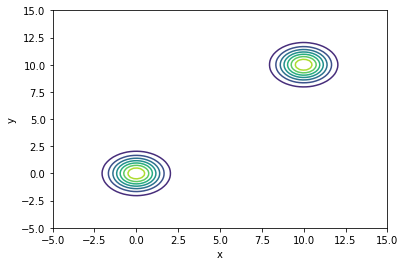

In [3]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Create log likelihood
log_likelihood = pints.toy.MultimodalGaussianLogPDF()

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_likelihood([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Sampling
Setup the sampler and run it.

In [4]:
# Select variance matrix of initial proposal dist
sigma0 = [[2, 0], [0, 2]]

# Create Bayesian problem
log_prior = pints.UniformLogPrior([-10, -10], [25, 25])

# Create SMC controller
smc = pints.SMCController(log_likelihood, log_prior, sigma0)

# Set number of temperatures (uniform on log scale)
smc.sampler().set_temperature_schedule(10)

# Set number of particles
smc.sampler().set_n_particles(5000)

# Set number of MCMC steps at each temperature
smc.sampler().set_n_kernel_samples(1)

# Run sampler
samples = smc.run()

Using Sequential Monte Carlo
Total number of particles: 5000
Number of temperatures: 10
Number of MCMC steps at each temperature: 1
Running in sequential mode.
Iter. Eval. Temperature ESS       Acc.      Time m:s
0     5000   0.9999      4998.698  0          0:00.7
1     10000  0.99972     4996.905  0.235153   0:03.1
2     15000  0.99923     4996      0.232      0:05.8
3     20000  0.99785     4972.851  0.235      0:08.3
4     25000  0.99401     4844.535  0.232      0:10.7
5     30000  0.98332     4429.626  0.23       0:13.2
6     35000  0.95358     3887.882  0.229      0:15.7
7     40000  0.87085     3452.663  0.226      0:18.2
8     45000  0.64062     3229.191  0.223      0:20.7


/home/michael/dev/pints/pints/_sequential/_SMC.py:330: RuntimeWarning: invalid value encountered in double_scalars
  return beta * fx + (1 - beta) * f_prior


9     50000  0           3169.287  0.215      0:23.2


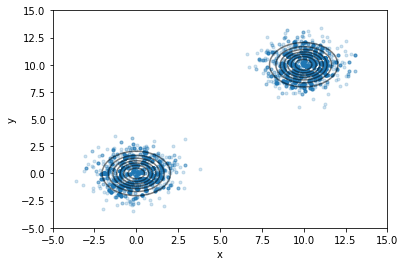

In [5]:
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(samples[:,0], samples[:,1], marker='.', alpha=0.2)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Post estimation

Look at distribution of weights on final particles.

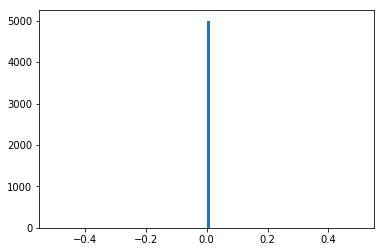

In [6]:
weights = smc.sampler().weights()
plt.hist(weights, 100)
plt.show()

Print the effective sample size based on the formula,

$ess = \frac{1}{\sum_{i=1}^k w_i^2},$

where $w_i$ is the weight of particule $i$.

In [7]:
print('ess = ', smc.sampler().ess())

ess =  3169.286687843748
